# Gluon interface example for `solar_10min`

This notebook contains an example of training the TACTiS model on the `solar_10min` dataset, using the same hyperparameters as in the paper, but with only a subset of the series to have faster training.

In [1]:
# Configuration
import os
import sys
REPO_NAME = "tactis"
def get_repo_basepath():
    cd = os.path.abspath(os.curdir)
    return cd[:cd.index(REPO_NAME) + len(REPO_NAME)]
REPO_BASE_PATH = get_repo_basepath()
sys.path.append(REPO_BASE_PATH)

In [2]:
from pts import Trainer
import torch
from tactis.gluon.estimator import TACTiSEstimator
from tactis.gluon.dataset import generate_backtesting_datasets
from tactis.gluon.metrics import compute_validation_metrics
from tactis.gluon.plots import plot_four_forecasts
from gluonts.evaluation.backtest import make_evaluation_predictions

/home/coder/anaconda3/envs/new_tactis/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


## Loading the dataset

This loads the dataset as it was used during the hyperparameter search experiments.

In [3]:
history_factor = 2
backtest_id = 4

metadata, train_data, test_data = generate_backtesting_datasets("solar_10min", backtest_id, history_factor)

/home/coder/anaconda3/envs/new_tactis/lib/python3.9/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/home/coder/anaconda3/envs/new_tactis/lib/python3.9/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/home/coder/anaconda3/envs/new_tactis/lib/python3.9/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/home/coder/anaconda3/envs/new_tactis/lib/python3.9/site-packages/gluonts/dataset/common.py:328: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  return pd.Timestamp(
/home/coder/anaconda3/envs/new_tactis/lib/python3.9/site-packages/glu

Delete all but the first 20 series from the dataset. This is due to the full dataset taking us 3 days to train in our benchmark.

In [4]:
for entry in train_data.list_data:
    entry["target"] = entry["target"][:20, :]
for entry in test_data.list_data:
    entry["target"] = entry["target"][:20, :]

## Creating the GluonTS Estimator object

The following hyperparameters (together with the history factor of 1) are those used in our benchmark for `solar_10min`, although with a reduced training time since we took a limit of 3 days for our benchmark.

In [5]:
estimator = TACTiSEstimator(
    model_parameters = {
        "series_embedding_dim": 5,
        "input_encoder_layers": 2,
        "input_encoding_normalization": True,
        "data_normalization": "standardization",
        "loss_normalization": "series",
        # "bagging_size": 20,
        "positional_encoding":{
            "dropout": 0.0,
        },
        "temporal_encoder":{
            "attention_layers": 1,
            "attention_heads": 1,
            "attention_dim": 24,
            "attention_feedforward_dim": 24,
            "dropout": 0.0,
        },
        "copula_decoder":{
            "min_u": 0.05,
            "max_u": 0.95,
            "attentional_copula": {
                "attention_heads": 3,
                "attention_layers": 2,
                "attention_dim": 8,
                "mlp_layers": 1,
                "mlp_dim": 48,
                "resolution": 20,
            },
            "dsf_marginal": {
                "mlp_layers": 1,
                "mlp_dim": 48,
                "flow_layers": 2,
                "flow_hid_dim": 16,
            },
        },
    },
    num_series = train_data.list_data[0]["target"].shape[0],
    history_length = history_factor * metadata.prediction_length,
    prediction_length = metadata.prediction_length,
    freq = metadata.freq,
    trainer = Trainer(
        epochs = 100,
        batch_size = 8,
        num_batches_per_epoch = 512,
        learning_rate = 1e-4,
        weight_decay = 0,
        maximum_learning_rate = 1e-4,
        clip_gradient = 1e3,
        device = torch.device("cuda"),
    ),
    cdf_normalization = False,
    num_parallel_samples = 100,
)

## The training

In [6]:
with torch.autograd.set_detect_anomaly(True):
    predictor = estimator.train(train_data)

  0%|          | 0/511 [00:00<?, ?it/s]

/home/coder/anaconda3/envs/new_tactis/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)


  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

## Metrics

Measuring the metrics on the testing dataset. Note that we use `split=False` due to the testing dataset already being split into multiple timestamps.

We reduce the batch size since we generate many samples in parallel (see the `num_parallel_samples` parameter of the Estimator object). The extra memory usage is somewhat compensated by not having to keep gradient information, but not completely.

Note that the energy score metric cannot be directly compared to the one for the full dataset, since the metric is not normalized by the number of series and their average amplitude.

In [7]:
predictor.batch_size = 2
metrics = compute_validation_metrics(
    predictor=predictor,
    dataset=test_data,
    window_length=estimator.history_length + estimator.prediction_length,
    num_samples=100,
    split=False,
)

In [8]:
metrics

{'CRPS': 0.3365468676935154,
 'ND': 0.4491919529948887,
 'NRMSE': 1.089520890754055,
 'MSE': 17.58298530488733,
 'CRPS-Sum': 0.2807562619981708,
 'ND-Sum': 0.351820713354757,
 'NRMSE-Sum': 0.7642943162672533,
 'MSE-Sum': 3461.0091916038878,
 'Energy': 103.25241032824715,
 'num_nan': 0,
 'num_inf': 0}

## Plotting the forecasts

Plot the forecast on multiple timestamps of the testing dataset.

In [9]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data, predictor=predictor, num_samples=100
)
forecasts = list(forecast_it)
targets = list(ts_it)

/home/coder/anaconda3/envs/new_tactis/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)


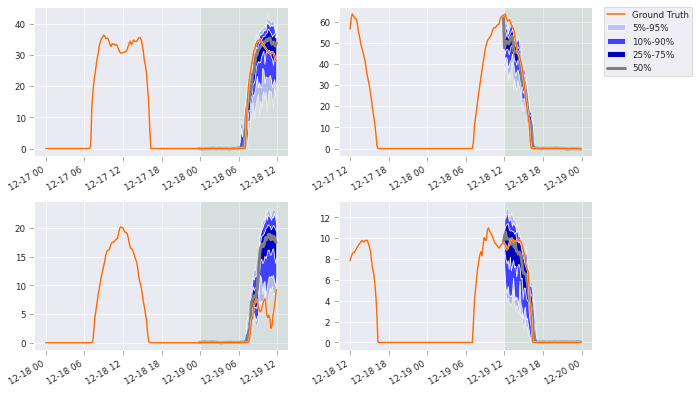

In [10]:
plot_four_forecasts(
    forecasts=forecasts,
    targets=targets,
    selection=[(0, 0), (1, 5), (2, 10), (3, 15)],
    tick_freq="6 hours",
    history_length=estimator.history_length,
)